## Support Vector Machine vs. Voted Perceptron

### Kernel gaussiano RBF

In [1]:
# Función para calcular el kernel gaussiano
kernel_gaussiano <- function(x, y, sigma) {
  return(exp(-sum((x - y)^2) / (2 * sigma^2)))
}

### Entrenamiento Voted Perceptron

In [2]:
# Función para entrenar el Voted Perceptron
voted_perceptron_entrenamiento <- function(datos_entrenamiento, etiquetas_entrenamiento, sigma, n_iteraciones) {
  n_ejemplos <- nrow(datos_entrenamiento)
  n_caracteristicas <- ncol(datos_entrenamiento)
  
  # Inicializar los pesos y votos
  W <- matrix(0, nrow = n_caracteristicas, ncol = n_iteraciones)
  C <- matrix(0, nrow = n_iteraciones, ncol = n_ejemplos)
  b <- 0
  
  for (iteracion in 1:n_iteraciones) {
    for (i in 1:n_ejemplos) {
      x <- datos_entrenamiento[i, ]
      y <- etiquetas_entrenamiento[i]
      
      # Calcular la predicción
      suma <- 0
      for (j in 1:n_ejemplos) {
        suma <- suma + C[iteracion, j] * kernel_gaussiano(datos_entrenamiento[j, ], x, sigma)
      }
      y_pred <- sign(suma + b)
      
      if (!is.na(y_pred) && !is.na(y) && y_pred * y <= 0) {
        # Actualizar los pesos y votos
        W[, iteracion] <- W[, iteracion] + y * x
        C[1, iteracion] <- C[1, iteracion] + 1
        b <- b + y
      }
    }
  }
  
  # Normalizar los pesos
  norm_factor <- sqrt(rowSums(W^2))
  W <- t(t(W) / norm_factor)
  
  return(list(W = W, b = b))
}

### Train Voted Perceptron

In [3]:
# Función para clasificar una muestra
voted_perceptron_clasificar <- function(muestra, pesos, sigma) {
  W <- pesos$W
  b <- pesos$b
  
  n_caracteristicas <- length(muestra)
  
  suma <- 0
  for (i in 1:n_caracteristicas) {
    suma <- suma + W[i] * kernel_gaussiano(muestra, datos_entrenamiento[i, ], sigma)
  }
  
  if (suma + b >= 0) {
    return(1)
  } else {
    return(-1)
  }
}

### Accuracy

In [4]:
# Función para calcular el accuracy
calcular_accuracy <- function(datos, etiquetas, pesos, sigma) {
  n_ejemplos <- nrow(datos)
  predicciones <- numeric(n_ejemplos)
  
  for (i in 1:n_ejemplos) {
    muestra <- datos[i, ]
    predicciones[i] <- voted_perceptron_clasificar(muestra, pesos, sigma)
  }
  
  accuracy <- sum(predicciones == etiquetas) / n_ejemplos
  
  return(accuracy)
}

## Datos de prueba

In [5]:
# Generar datos de entrenamiento
set.seed(123)  # Establecer semilla para reproducibilidad
n <- 1000  # Número de ejemplos
m <- 10  # Número de características

datos_entrenamiento <- matrix(runif(n * m), ncol = m)
etiquetas_entrenamiento <- 2 * as.integer(runif(n) > 0.5) - 1

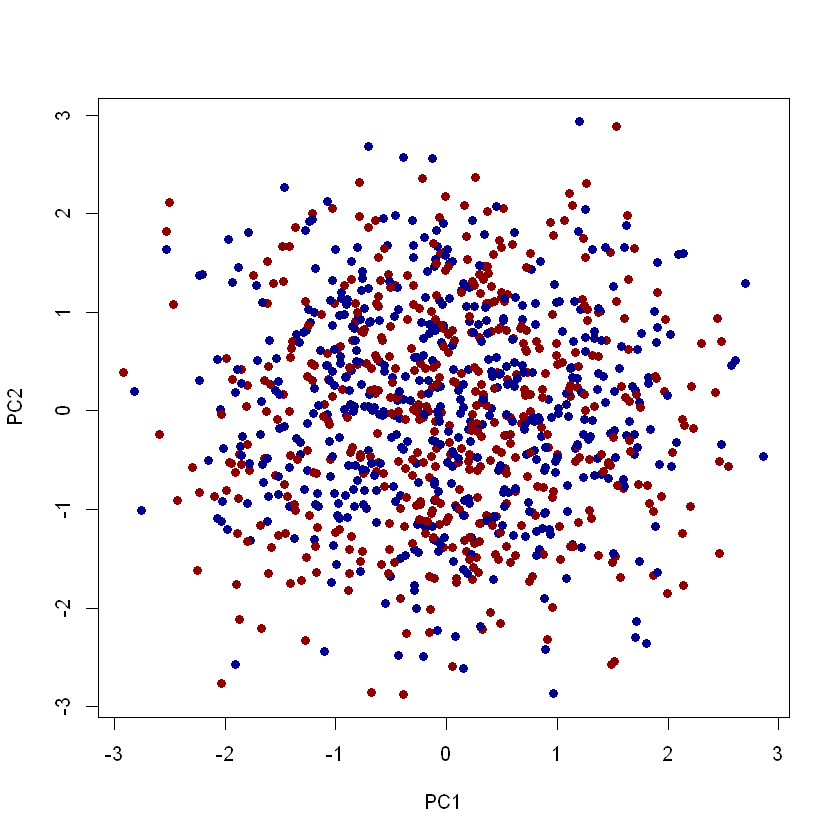

In [6]:
# PCA
pca <- prcomp(datos_entrenamiento, scale. = TRUE, center = TRUE, retx = TRUE)

reduced_data <- pca$x

# Scatter plot
plot(reduced_data, col = ifelse(etiquetas_entrenamiento == 1, "darkblue", "darkred"), pch = 16)

## Voted Perceptron Kernelizado

In [7]:
# Parámetros del kernel gaussiano
sigma <- 1

# Entrenar el Voted Perceptron
n_iteraciones <- 50
pesos <- voted_perceptron_entrenamiento(datos_entrenamiento, etiquetas_entrenamiento, sigma, n_iteraciones)

# Calcular predicciones para los datos de entrenamiento del Voted Perceptron
predicciones_voted_perceptron <- sapply(1:nrow(datos_entrenamiento), function(i) voted_perceptron_clasificar(datos_entrenamiento[i,], pesos, sigma))

[1] "Accuracy en datos de entrenamiento: 0.504"


## Support Vector Machine

In [9]:
library(e1071)

etiquetas_entrenamiento <- as.factor(etiquetas_entrenamiento)

# Entrenar SVM no lineal con kernel gaussiano
svm_model <- svm(factor(etiquetas_entrenamiento) ~ ., data = datos_entrenamiento, kernel = "radial", cost = 5, gamma = 0.5, scale = FALSE)

# Calcular predicciones para los datos de entrenamiento
predicciones_svm <- predict(svm_model, datos_entrenamiento)

## Accuracy

In [10]:
# Calcular accuracy para Voted Perceptron
accuracy_voted_perceptron <- sum(predicciones_voted_perceptron == etiquetas_entrenamiento) / length(etiquetas_entrenamiento)

# Calcular accuracy para SVM
accuracy_svm <- sum(as.integer(predicciones_svm) == etiquetas_entrenamiento) / length(etiquetas_entrenamiento)

# Resultados
print(paste("Accuracy SVM:", accuracy_svm))
print(paste("Accuracy Voted Perceptron:", accuracy_voted_perceptron))

[1] "Accuracy SVM: 0.152"
[1] "Accuracy Voted Perceptron: 0.504"


## ROC/AUC

Type 'citation("pROC")' for a citation.


Attaching package: 'pROC'


The following objects are masked from 'package:stats':

    cov, smooth, var


Setting levels: control = 1, case = 2

Setting direction: controls < cases



[1] "Área bajo la curva (AUC): 0.687051971326165"


Setting levels: control = 1, case = 2

Setting direction: controls < cases



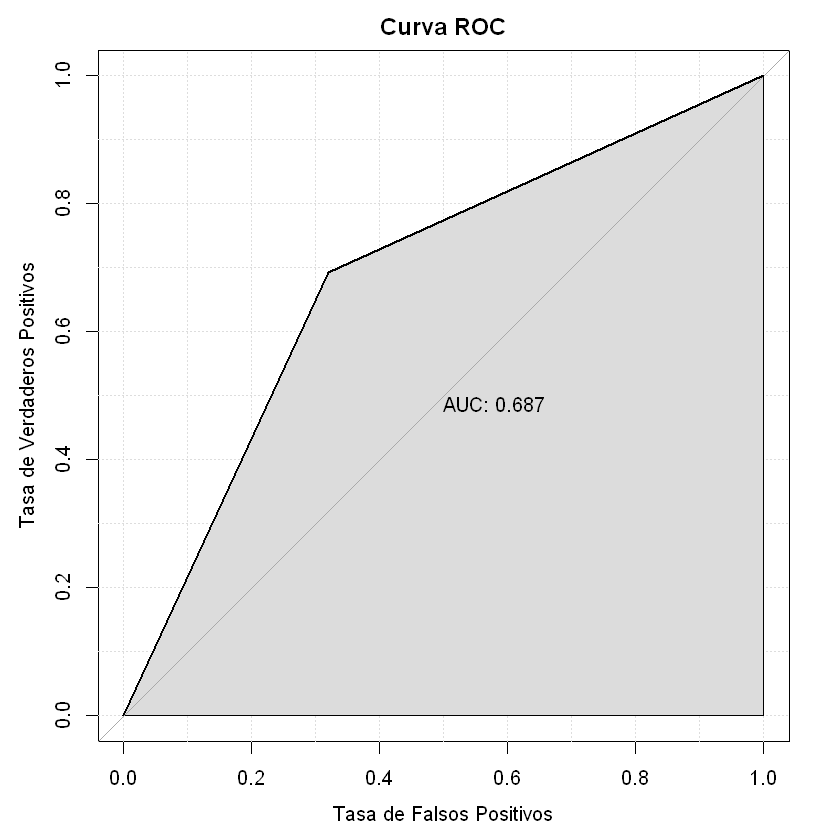

[1] "Área bajo la curva (AUC): 0.5"


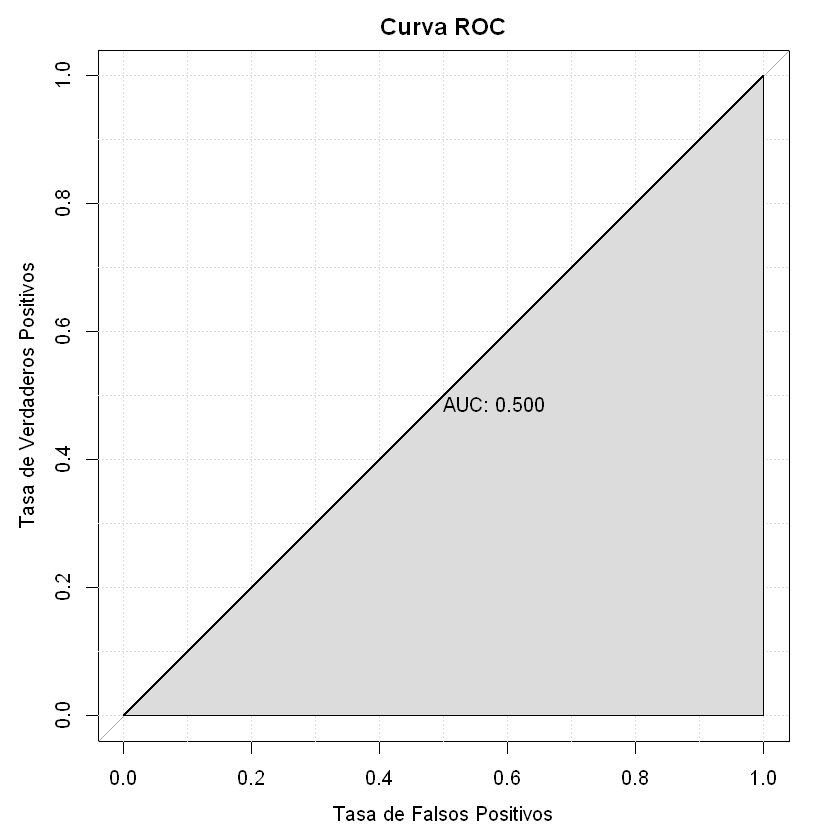

In [11]:
library(pROC)

# Crear una función para generar la curva ROC
generar_curva_ROC <- function(predicciones, etiquetas) {
  predicciones_numericas <- as.numeric(predicciones)
  etiquetas_numericas <- as.numeric(etiquetas)
  curva_roc <- roc(etiquetas_numericas, predicciones_numericas)
  plot(curva_roc, 
    print.auc = TRUE, 
    auc.polygon = TRUE, 
    grid = TRUE, 
    legacy.axes = TRUE,
    main = "Curva ROC", 
    xlab = "Tasa de Falsos Positivos", 
    ylab = "Tasa de Verdaderos Positivos"
  )
  auc <- auc(curva_roc)
  print(paste("Área bajo la curva (AUC):", auc))
}

# Generar curva ROC para SVM
generar_curva_ROC(predicciones_svm, etiquetas_entrenamiento)

# Generar curva ROC para Voted Perceptron
generar_curva_ROC(predicciones_voted_perceptron, etiquetas_entrenamiento)
